<a href="https://colab.research.google.com/github/nabilLearns/Deeply-Supervised-Nets/blob/master/DSN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get required modules

In [ ]:
import torch # Used for model definition and training
import torch.nn as nn
import torchvision
import numpy as np # Used to compute model accuracy
import pandas as pd # Used to process dataset and create a train/val/test split
import matplotlib.pyplot as plt # Used to plot model performance (i.e. loss, accuracy)
import os

In [ ]:
!pip --quiet install wget # Used to download dataset from a url

## Download Dataset

In [ ]:
# Download dataset in an .arff file into the current working directory

import wget, requests, io, shutil
from zipfile import ZipFile

data_url = "https://www.muratkoklu.com/datasets/vtdhnd06.php"
req = requests.get(data_url)
zip_file = ZipFile(io.BytesIO(req.content))
path = os.path.join(os.getcwd())
zip_file.extractall(path)

shutil.move(os.path.join(os.getcwd(),'Date_Fruit_Datasets/Date_Fruit_Datasets.arff'), os.path.join(os.getcwd(), 'Date_Fruit_Datasets.arff'))
shutil.rmtree(os.path.join(os.getcwd(),'Date_Fruit_Datasets'))

In [ ]:
# Python script that converts the downloaded .arff file to .csv (I did not write this)
# Source: https://github.com/haloboy777/arfftocsv/blob/master/arffToCsv.py

#########################################
# Project   : ARFF to CSV converter     #
# Created   : 10/01/17 11:08:06         #
# Author    : haloboy777                #
# Licence   : MIT                       #
#########################################

# Getting all the arff files from the current directory
files = [arff for arff in os.listdir('.') if arff.endswith(".arff")]
print(files)

# Function for converting arff list to csv list
def toCsv(text):
    data = False
    header = ""
    new_content = []
    for line in text:
        if not data:
            if "@ATTRIBUTE" in line or "@attribute" in line:
                attributes = line.split()
                if("@attribute" in line):
                    attri_case = "@attribute"
                else:
                    attri_case = "@ATTRIBUTE"
                column_name = attributes[attributes.index(attri_case) + 1]
                header = header + column_name + ","
            elif "@DATA" in line or "@data" in line:
                data = True
                header = header[:-1]
                header += '\n'
                new_content.append(header)
        else:
            new_content.append(line)
    return new_content


# Main loop for reading and writing files
for file in files:
    with open(file, "r") as inFile:
        content = inFile.readlines()
        name, ext = os.path.splitext(inFile.name)
        new = toCsv(content)
        with open(name + ".csv", "w") as outFile:
            outFile.writelines(new)

['Date_Fruit_Datasets.arff']


## Preprocess Data

In [ ]:
data = pd.read_csv("Date_Fruit_Datasets.csv")
print(data['Class'].unique())
print(data.info())
data # As you can see, the values need to be normalized

['BERHI' 'DEGLET' 'DOKOL' 'IRAQI' 'ROTANA' 'SAFAVI' 'SOGAY']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float6

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.9080,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.1440,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.3940,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.2100,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.3540,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,255403,1925.3650,691.8453,477.1796,0.7241,570.2536,0.9785,261028,0.7269,1.4499,...,2.2423,2.3704,2.7202,-25296416768,-19168882688,-18473392128,49.0869,43.0422,42.4153,SOGAY
894,365924,2664.8230,855.4633,551.5447,0.7644,682.5752,0.9466,386566,0.6695,1.5510,...,3.4109,3.5805,3.9910,-31605219328,-21945366528,-19277905920,46.8086,39.1046,36.5502,SOGAY
895,254330,1926.7360,747.4943,435.6219,0.8126,569.0545,0.9925,256255,0.7240,1.7159,...,2.2759,2.5090,2.6951,-22242772992,-19594921984,-17592152064,44.1325,40.7986,40.9769,SOGAY
896,238955,1906.2679,716.6485,441.8297,0.7873,551.5859,0.9604,248795,0.6954,1.6220,...,2.6769,2.6874,2.7991,-26048595968,-21299822592,-19809978368,51.2267,45.7162,45.6260,SOGAY


### Generate train/val/test data splits

In [ ]:
# Generate train/val/test data splits

normalized = (data.iloc[:,:-1] - data.iloc[:,:-1].mean()) / data.iloc[:,:-1].std()
data.iloc[:,:-1] = normalized
data['Class'] = data['Class'].astype('category').cat.codes + 1 # convert string class labels to numbers

print(f"Converted class codes: {data['Class'].unique()}")
train, val, test = {}, {}, {}
for date_type in data['Class'].unique():

    num_examples = data[data['Class'] == date_type].shape[0]
    data[data['Class'] == date_type] = data[data['Class'] == date_type].sample(frac=1, random_state=42) # shuffle data

    train[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[0:int(num_examples*0.8)]
    val[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[int(num_examples*0.8):int(num_examples*0.9)]
    test[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[int(num_examples*0.9):]

    print(f"Class {date_type} Shape (#examples, #features): {train[date_type].shape}")

train, val, test = [pd.concat(split).sample(frac=1, random_state=1).reset_index(drop=True) for split in [train, val, test]]

Converted class codes: [1 2 3 4 5 6 7]
Class 1 Shape (#examples, #features): (52, 35)
Class 2 Shape (#examples, #features): (78, 35)
Class 3 Shape (#examples, #features): (163, 35)
Class 4 Shape (#examples, #features): (57, 35)
Class 5 Shape (#examples, #features): (132, 35)
Class 6 Shape (#examples, #features): (159, 35)
Class 7 Shape (#examples, #features): (75, 35)


### Get data and label tensors from each dataframe split

In [ ]:
# Get data and label tensors from each split dataframe

X_train = torch.Tensor(train.values[:,:-1])
Y_train = torch.Tensor(train.values[:,-1])

X_val = torch.Tensor(val.values[:,:-1])
Y_val = torch.Tensor(val.values[:,-1])

X_test = torch.Tensor(test.values[:,:-1])
Y_test = torch.Tensor(test.values[:,-1])

In [ ]:
print(X_train.shape)

torch.Size([716, 34])


## Define Model Architecture and Loss

In [ ]:
# Define model
torch.manual_seed(0)

class Network(nn.Module):
    def __init__(self, n_in=34, n_hidden=[50, 100, 50], n_classes=7):
        super(Network, self).__init__()
        self.mapping1 = nn.Linear(n_in, n_hidden[0])

        self.mapping2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.mapping3 = nn.Linear(n_hidden[1], n_hidden[1])
        self.mapping4 = nn.Linear(n_hidden[1], n_hidden[2])

        self.mapping5 = nn.Linear(n_hidden[2], n_classes)
        self.relu = nn.ReLU()

        self.svm_1 = torch.ones((n_hidden[0],1), requires_grad=True)
        nn.init.xavier_uniform_(self.svm_1)

        self.svm_2 = torch.ones((n_hidden[1],1), requires_grad=True)
        nn.init.xavier_uniform_(self.svm_2)

        self.svm_3 = torch.ones((n_hidden[1],1), requires_grad=True)
        nn.init.xavier_uniform_(self.svm_3)

        self.svm_4 = torch.ones((n_hidden[2],1), requires_grad=True)
        nn.init.xavier_uniform_(self.svm_4)

        self.svm_5 = torch.ones((n_classes,1), requires_grad=True)
        nn.init.xavier_uniform_(self.svm_5)

    def forward(self, x):
        """
        Returns a list containing feature maps and svm weights for each layer. The svm weights do not
        directly affect the model in forward(). Rather, they are used in companion_loss() and act as an
        "additional constraint (or a new regularization) to the learning process" [Gallagher et. al, 2014]
        """

        f_map1 = self.relu(self.mapping1(x))
        f_map2 = self.relu(self.mapping2(f_map1))
        f_map3 = self.relu(self.mapping3(f_map2))
        f_map4 = self.relu(self.mapping4(f_map3))
        f_map5 = self.mapping5(f_map4)

        svm_1 = self.svm_1
        svm_2 = self.svm_2
        svm_3 = self.svm_3
        svm_4 = self.svm_4
        svm_5 = self.svm_5
                
        return [f_map1, f_map2, f_map3, f_map4, f_map5, svm_1, svm_2, svm_3, svm_4, svm_5]


def companion_loss(f_map, svm_w, t_labels, n_labels=7):
    """
    Implements L2-SVM companion objective loss described by equations (4) and (5) of the "Deeply Supervised Nets" paper ([Gallagher et. al, 2014])

    parameters
    ----------
    f_map: tensor of shape (BATCH_SIZE x NUM_FEATURES)
    svm_w: svm weights
    t_labels: vector of labels

    some variable(s)
    --------------
    f_labels: A torch tensor of shape (# examples, 6). Each row holds the 6 incorrect labels for a given example.
    """

    loss = 0
    all_labels = torch.arange(n_labels) + 1
    f_labels = torch.stack([all_labels[all_labels != t_labels[i]] for i in range(len(t_labels))])
    svm_pred = (f_map @ svm_w)

    # < w^(m), (Z^(m), y) >
    true_label_svm = svm_pred * torch.unsqueeze(t_labels,dim=0).T # torch.Size([# examples, 1])
    
    # < w^(m), (Z^(m), y_k) > for all k
    f_labels_svm = svm_pred * f_labels # torch.Size([# examples, 6])
    loss = torch.sum(torch.nn.functional.relu(1 - (true_label_svm - f_labels_svm))**2)
    
    return loss

#global_loss = lambda data: torch.sum([companion_loss(f_map) for f_map in Network(data)])
def global_loss(model_out: list, Y, alphas: list, gamma = 20):
    """
    Return overall combined objective function as specified in eq. (3) of [Gallagher et. al, 2014]
    
    parameters
    ----------
    model_out: [f_map1, f_map2, f_map3, svm1, svm2, svm3]
    alphas: These terms act as a weight for each layers' error, indicating its importance to the model (see eq. (3), and pg. 4 of [Gallagher et. al, 2014])
    gamma: This acts as a threshold. If the svm weights and companion loss for a given layer are too low, they are ignored by global_loss. See pg. 4 of [Gallagher et. al, 2014]
    """

    n_layers = len(model_out) // 2
    companion_losses = [companion_loss(model_out[m], model_out[m+n_layers], Y) for m in range(n_layers)]
    modified_companion_losses = [alphas[m] * torch.nn.functional.relu(torch.linalg.norm(model_out[m + n_layers])**2 + companion_losses[m] - gamma) for m in range(n_layers - 1)]
    f_layer_loss = torch.linalg.norm(model_out[-1])**2 + companion_losses[-1]
    global_loss = f_layer_loss + sum(modified_companion_losses)

    return global_loss

## Train DSN and plot performance

In [ ]:
def train(num_epochs = 250):
    """Train DSN model for num_epochs, print diagnostic information (norm of SVM weights at output layer), and plot model performance"""
    
    opt = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=0.9, weight_decay=0.01)
    epoch_train_losses = []
    epoch_train_accs = []
    epoch_val_losses = []
    epoch_val_accs = []
    alphas = [6, 2, 3, 4]
    
    for epoch in range(num_epochs):
        avg_train_loss = 0
        avg_val_loss = 0
        train_acc = 0
        val_acc = 0

        if epoch % (int)(num_epochs*0.2) == 0 and epoch != 0:
            print(f"EPOCH {epoch}")
            print(torch.linalg.norm(model(X_train)[-1].grad))
            
        batch_sz = 125
        alphas = [a * 0.1 * (1 - epoch / num_epochs) for a in alphas]
        
        for batch_idx in range(0, X_train.shape[0], batch_sz):

            opt.zero_grad()
            L = global_loss(model(X_train[batch_idx:batch_idx+batch_sz]), Y_train[batch_idx:batch_idx+batch_sz], alphas)
            L.backward()
            opt.step()

            avg_train_loss += L.item()
            train_batch_pred = torch.argmax(model(X_train[batch_idx:batch_idx+batch_sz])[4],dim=1) + 1 # index [2] for 3 layer network
            train_batch_true = Y_train[batch_idx:batch_idx+batch_sz]
            train_acc += np.array(train_batch_pred == train_batch_true).sum()

        
        for batch_idx in range(0, X_val.shape[0], batch_sz):
            avg_val_loss += global_loss(model(X_val[batch_idx:batch_idx+batch_sz]), Y_val[batch_idx:batch_idx+batch_sz], alphas).item()
            val_batch_pred = torch.argmax(model(X_val[batch_idx:batch_idx+batch_sz])[4],dim=1)+1
            val_batch_true = Y_val[batch_idx:batch_idx+batch_sz]
            val_acc += np.array(val_batch_pred == val_batch_true).sum()
        
    
        epoch_train_losses.append(avg_train_loss / X_train.shape[0])
        epoch_train_accs.append(train_acc / X_train.shape[0])
        epoch_val_losses.append(avg_val_loss / X_val.shape[0])
        epoch_val_accs.append(val_acc / X_val.shape[0])
        
    plt.title("Train vs. Validation Loss")
    plt.plot(epoch_train_losses, label="Train")
    plt.plot(epoch_val_losses, label="Validation")
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()

    plt.title("Train vs. Validation Accuracy")
    plt.plot(epoch_train_accs, label="Train")
    plt.plot(epoch_val_accs, label="Validation")
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch #')
    plt.show()
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

EPOCH 50
tensor(6534.3877)
EPOCH 100
tensor(8415.3379)
EPOCH 150
tensor(10193.0977)
EPOCH 200
tensor(12078.5928)


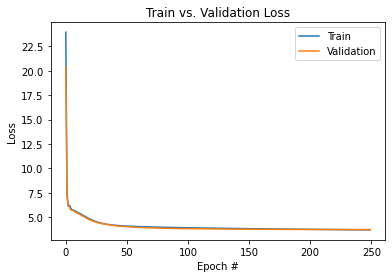

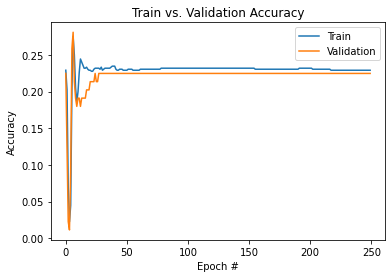

In [ ]:
model = Network()
epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = train() 
# Every couple of epochs, the current epoch is printed as well as the L2 norm of svm weights at the final layer

In [ ]:
def inspect_model(model):
    """Prints model predictions and weights at the output layer"""

    print((torch.argmax(model(X_train)[4],dim=1)).unique())
    print(model(X_train)[2])

    # Examine model weights
    f1, f2, f3, f4, f5, s1, s2, s3, s4, s5 = model(X_train[0:1000])
    print([a.shape for a in [f1, f2, f3, f4, f5, s1, s2, s3, s4, s5]])
    print(f"{f1} \n\n  {f2} \n\n {f3}")